## Import Libraries

Import all necessary libraries for data manipulation, visualization, and modeling.

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

### Read the CSV File

Load the insurance dataset and display its shape and first few rows.

In [85]:
import pandas as pd

# Load your dataset
df = pd.read_csv(r"C:\Users\Student\Downloads\JoyP\Medical-Cost-Prediction-Smoking-Risk-Classification\Data\insurance.csv")  # adjust path/filename as needed

# Show columns and types
print(df.shape)
df.head()


(228711, 42)


,ID,ID_policy,ID_insured,period,date_effect_insured,date_lapse_insured,date_effect_policy,date_lapse_policy,year_effect_insured,year_lapse_insured,...,C_H,C_GI,C_II,C_IE_P,C_IE_S,C_IE_T,C_GE_P,C_GE_S,C_GE_T,C_C
0,1_1,1,1,2017,6/15/1993,12/20/2017,6/15/1993,NaN,1993,2017.0,...,H1,99.0,85.0,18.0,52.0,59.0,4.0,14.0,96.0,C6
1,1_2,1,2,2017,6/15/1993,NaN,6/15/1993,NaN,1993,NaN,...,H1,99.0,85.0,18.0,52.0,59.0,4.0,14.0,96.0,C6
2,2_1,2,1,2017,6/16/1993,NaN,6/16/1993,NaN,1993,NaN,...,H6,100.0,94.0,26.0,11.0,85.0,7.0,1.0,100.0,C6
3,3_3,3,3,2017,6/15/1993,NaN,6/15/1993,NaN,1993,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3_5,3,5,2017,6/15/1993,NaN,6/15/1993,NaN,1993,NaN,...,H6,99.0,81.0,32.0,34.0,69.0,9.0,4.0,98.0,C6


### Data Overview

Check the data types, summary statistics, and missing values.

In [86]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228711 entries, 0 to 228710
Data columns (total 42 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    228711 non-null  object 
 1   ID_policy             228711 non-null  int64  
 2   ID_insured            228711 non-null  int64  
 3   period                228711 non-null  int64  
 4   date_effect_insured   228711 non-null  object 
 5   date_lapse_insured    61530 non-null   object 
 6   date_effect_policy    228711 non-null  object 
 7   date_lapse_policy     54143 non-null   object 
 8   year_effect_insured   228711 non-null  int64  
 9   year_lapse_insured    61530 non-null   float64
 10  year_effect_policy    228711 non-null  int64  
 11  year_lapse_policy     54143 non-null   float64
 12  exposure_time         228711 non-null  float64
 13  lapse                 228711 non-null  int64  
 14  seniority_insured     228711 non-null  int64  
 15  

,ID_policy,ID_insured,period,year_effect_insured,year_lapse_insured,year_effect_policy,year_lapse_policy,exposure_time,lapse,seniority_insured,...,IICIMUN,IICIPROV,C_GI,C_II,C_IE_P,C_IE_S,C_IE_T,C_GE_P,C_GE_S,C_GE_T
count,228711.000000,228711.000000,228711.000000,228711.000000,61530.000000,228711.000000,54143.000000,228711.000000,228711.000000,228711.000000,...,217825.000000,223010.000000,215498.000000,215498.000000,215498.000000,215498.000000,215498.000000,215498.000000,215498.000000,215498.000000
mean,20629.465220,13.944708,2017.990481,2005.213768,2018.156021,2004.294017,2018.156327,0.935408,2.038232,12.776714,...,6.897728,4.247796,81.496705,50.485411,50.484167,50.484148,50.485462,20.044887,26.658336,84.137069
std,12236.581187,95.049800,0.822491,13.053458,0.786350,13.988405,0.782587,0.232527,0.423944,13.014838,...,6.443880,2.739184,23.241767,28.868616,28.868581,28.868551,28.868536,17.660667,28.095859,19.854768
min,1.000000,1.000000,2017.000000,1933.000000,2017.000000,1932.000000,2017.000000,0.000000,1.000000,0.000000,...,0.010000,0.010000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,9800.000000,1.000000,2017.000000,1996.000000,2018.000000,1995.000000,2018.000000,1.000000,2.000000,2.000000,...,1.650000,1.290000,74.000000,25.000000,25.000000,25.000000,25.000000,7.000000,3.000000,77.000000
50%,20502.000000,2.000000,2018.000000,2009.000000,2018.000000,2008.000000,2018.000000,1.000000,2.000000,9.000000,...,5.600000,4.920000,92.000000,50.000000,50.000000,50.000000,50.000000,14.000000,14.000000,93.000000
75%,31306.000000,3.000000,2019.000000,2016.000000,2019.000000,2016.000000,2019.000000,1.000000,2.000000,22.000000,...,11.100000,5.310000,98.000000,75.000000,75.000000,75.000000,75.000000,29.000000,46.000000,99.000000
max,45162.000000,1886.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,1.000000,3.000000,86.000000,...,263.160000,10.490000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [87]:
df.isnull().sum()

ID                           0
ID_policy                    0
ID_insured                   0
period                       0
date_effect_insured          0
date_lapse_insured      167181
date_effect_policy           0
date_lapse_policy       174568
year_effect_insured          0
year_lapse_insured      167181
year_effect_policy           0
year_lapse_policy       174568
exposure_time                0
lapse                        0
seniority_insured            0
seniority_policy             0
type_policy                  0
type_policy_dg               0
type_product                 0
reimbursement                0
new_business                 0
distribution_channel         0
gender                       0
age                          0
premium                      0
cost_claims_year             0
n_medical_services           0
n_insured_pc                 0
n_insured_mun                0
n_insured_prov               0
IICIMUN                  10886
IICIPROV                  5701
C_H     

### Select Columns

Keep only the relevant features and the target variable.

In [88]:
selected_cols = [
    'age', 'gender', 'premium', 'n_medical_services',
    'distribution_channel', 'type_policy', 'type_product', 'cost_claims_year'
]
df = df[selected_cols].copy()

### Impute Missing Values

Fill missing values in numerical columns with the median and in categorical columns with the mode.

In [89]:
num_cols = ['age', 'premium', 'n_medical_services', 'cost_claims_year']
cat_cols = ['gender', 'distribution_channel', 'type_policy', 'type_product']

for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

### Outlier Detection

Visualize outliers in numeric columns using boxplots.

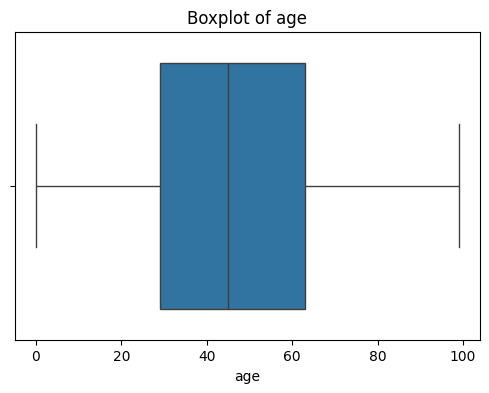

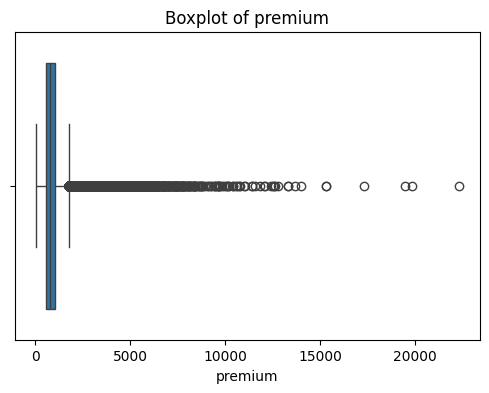

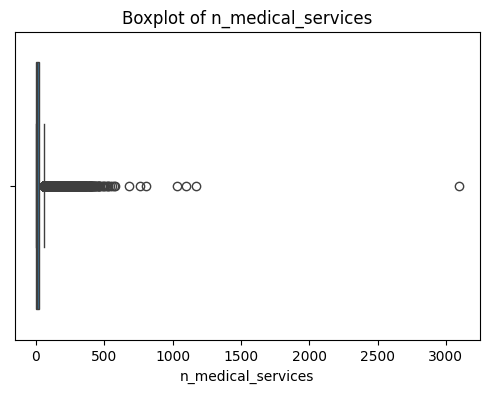

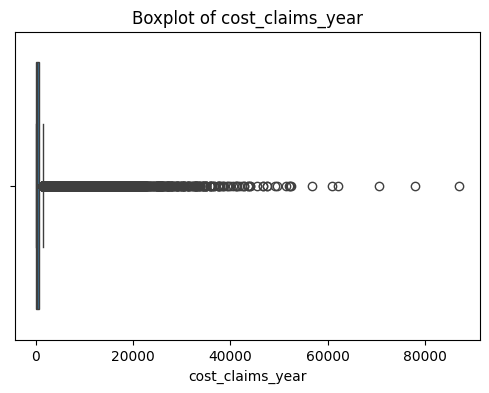

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numeric features to check for outliers
numeric_cols = ['age', 'premium', 'n_medical_services', 'cost_claims_year']

# Boxplot for each
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


### Outlier Treatment

Replace outliers in numeric columns with the mean value.

In [91]:
# Function to get IQR bounds
def get_outlier_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

# Replace outliers with mean
numeric_cols = ['age', 'premium', 'n_medical_services', 'cost_claims_year']

for col in numeric_cols:
    lower, upper = get_outlier_bounds(df[col])
    mean_val = df[col].mean()
    
    # Replace lower outliers
    df.loc[df[col] < lower, col] = mean_val
    # Replace upper outliers
    df.loc[df[col] > upper, col] = mean_val


### Label Encoding

Convert categorical columns to numeric using LabelEncoder.

In [92]:
encode_cols = ['gender', 'distribution_channel', 'type_policy', 'type_product']
le_dict = {}
for col in encode_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

### Correlation Heatmap

Visualize correlations between numerical features.

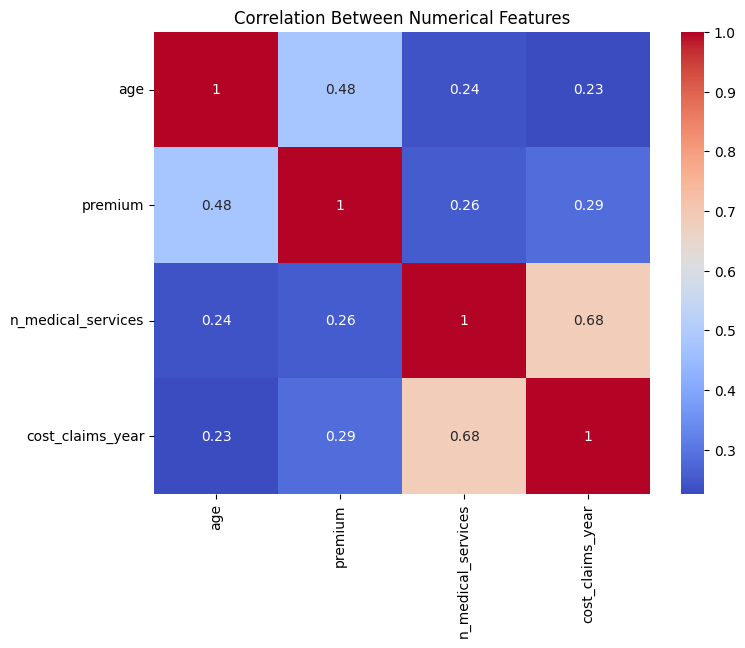

In [93]:
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Numerical Features")
plt.show()

### Distribution Plots

Plot the distribution of each numeric column.

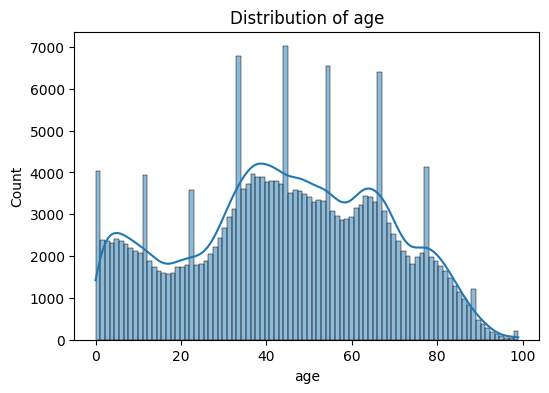

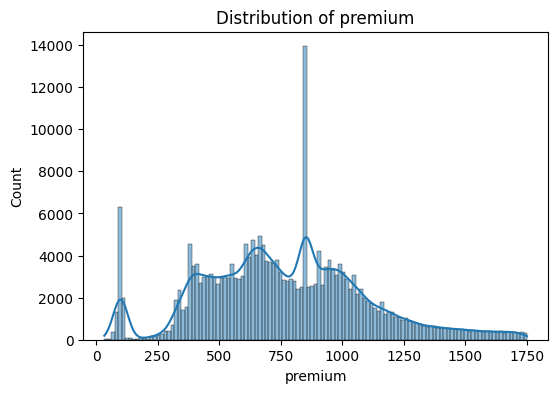

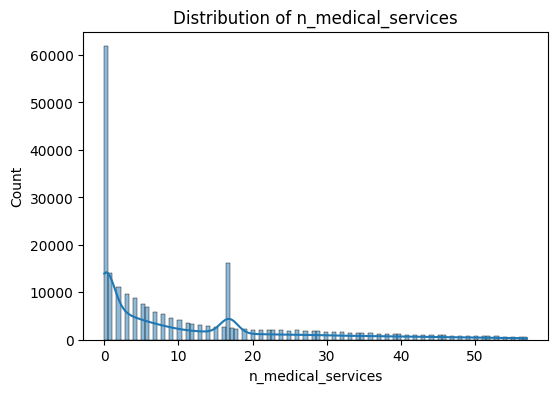

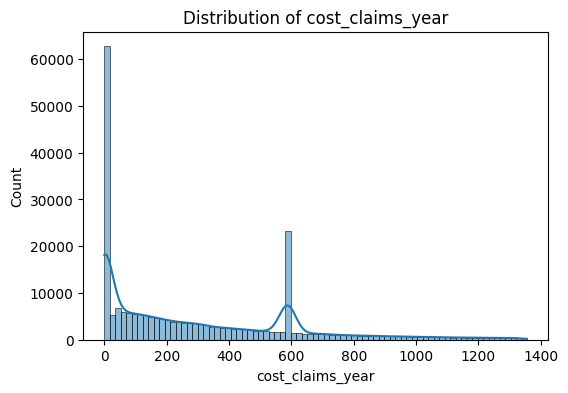

In [94]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

### Feature Engineering

Create new features: age group and premium per service.

In [95]:
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 50, 100], labels=['Young', 'Adult', 'Senior'])
df['premium_per_service'] = df['premium'] / (df['n_medical_services'] + 1)

### Define Features and Target

Separate the features (X) and target variable (y).

In [96]:
X = df.drop('cost_claims_year', axis=1)
y = df['cost_claims_year']

### Feature Scaling

Standardize the feature set.

In [98]:
# ===============================
# Step: Feature Scaling with StandardScaler
# ===============================

# Import the scaler
from sklearn.preprocessing import StandardScaler

# Select numeric columns to scale (exclude target variable)
numeric_cols = ['age', 'premium', 'n_medical_services', 'premium_per_service']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit scaler on the data and transform the numeric columns
# Using .loc to avoid SettingWithCopyWarning
df.loc[:, numeric_cols] = scaler.fit_transform(df.loc[:, numeric_cols])

# Now your numeric features are scaled with mean=0 and std=1


### Train-Test Split

Split the data into training and testing sets.

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


### Train Linear Regression

Fit a linear regression model and predict on the test set.

In [100]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

### Train Random Forest Regressor

Fit a random forest regressor and predict on the test set.

In [101]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [105]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

In [ ]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

### Model Evaluation

Evaluate both models using MAE, RMSE, and R2 metrics.

In [ ]:
def evaluate_model(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Results:")
    print(f" MAE: {mae:.2f}")
    print(f" RMSE: {rmse:.2f}")
    print(f" R2: {r2:.3f}\n")

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_gbr, "Gradient Boosting")
evaluate_model(y_test, y_pred_svr, "Support Vector Regression")

Linear Regression Results:
 MAE: 139.44
 RMSE: 204.04
 R2: 0.570

Random Forest Results:
 MAE: 114.10
 RMSE: 189.71
 R2: 0.628



### Visualization: Actual vs Predicted

Plot actual vs predicted costs for the Random Forest model.

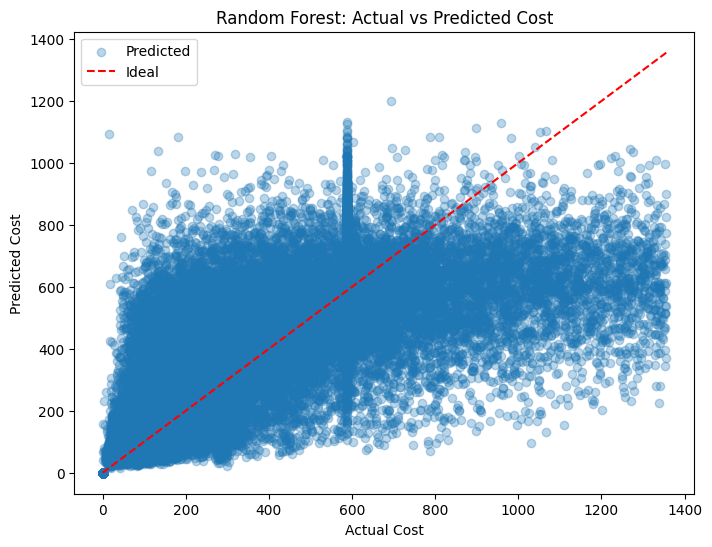

In [103]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel("Actual Cost")
plt.ylabel("Predicted Cost")
plt.title("Random Forest: Actual vs Predicted Cost")
plt.legend()
plt.show()


<!-- (Optional) Add further analysis or conclusion here. -->